This code implements the G-VAMP, for the generalized linear models. However, it does not include the EM-based estimation of the parameters of (1) noises for beta, (2) noises for z, (3) parameters of the distribution of Y

We need to add 

(1) EM updates of the parameters of the prior on beta (spike + mixture of Gaussinans); <br>
(2) Parameters of p y | z. These are the parameters of the Weibull / Gumbell distributions for instance. This includes modeling the noise of the measurements Y. Further, the prior on z is not separated out since the distribution of z is related to that of beta

In [127]:
# vampW code

from scipy.stats import norm
import numpy as np
import sympy
import scipy

# definition of Euler-Mascheroni constant
emc = float( sympy.S.EulerGamma.n(10) )

class prior:
    la = 0.5

    sigmas = [1]
    omegas = [1]
    def __init__(self, la, sigmas, omegas):
        self.la = la
        self.sigmas = sigmas
        self.omegas = omegas
    
def den_beta(r,gam1,prior): # checked!
    """
    This function returns the conditional expectation of the coefficients beta given the noisy estimate r
    The expectation is of the posterior distribution with the form of Spike and Slab mixture of Gaussians
    """
    A = (1-prior.la) * norm.pdf(r, loc=0, scale=np.sqrt(1.0/gam1)) # scale = standard deviation
    B = prior.la * norm.pdf(r, loc=0, scale=np.sqrt(prior.sigmas[0] + 1.0/gam1))

    # How is this derived???
    # Is the sigma coming from the prior???
    # Note that gam1 * r / (gam1 + 1/sigma) = r / (1+1/(sigma*gam1)) = sigma * r / (sigma + 1/gam1)
    # This is equivalent to the formulation in the paper
    ratio = gam1 * r / (gam1 + 1/prior.sigmas[0]) * B / (A + B)
    return ratio


def der_den_beta(r,gam1,prior): # checked!
    A = (1-prior.la) * norm.pdf(r, loc=0, scale=np.sqrt(1.0/gam1))
    B = prior.la * norm.pdf(r, loc=0, scale=np.sqrt(prior.sigmas[0] + 1.0/gam1))
    print("B / (A+B) = ", B[1] / (A[1]+B[1]))
    Ader = A * (-r*gam1)
    Bder = B * (-r) / (prior.sigmas[0] + 1.0/gam1)
    BoverAplusBder = ( Bder * A - Ader * B ) / (A+B) / (A+B)
    print("gam1 / (gam1 + 1/sigma) = ", gam1 / (gam1 + 1/prior.sigmas[0]))
    print("alpha1 part I = ", gam1 / (gam1 + 1/prior.sigmas[0]) * B[1] / (A[1] + B[1]))
    print("alpha2 part II = ", BoverAplusBder[1] * r[1] * gam1 / (gam1 + 1.0/prior.sigmas[0]) )
    ratio = gam1 / (gam1 + 1/prior.sigmas[0]) * B / (A + B) + BoverAplusBder * r * gam1 / (gam1 + 1.0/prior.sigmas[0])
    return ratio

def den_z_non_lin_eq(z, tau1, p1, y, alpha, mu): # checked!
    res = tau1 * (z-p1) + alpha - alpha * np.power(y, alpha) * np.exp(- alpha * (mu + z) - emc)
    return res
    
def den_z(p1, tau1, y, alpha, mu): # checked!
    """
    Performs component-wise optimization of the parameters z_i
    We assume independence of parameters of z_i 
    """
    n,_ = p1.shape
    out = np.zeros((n,1))
    for i in range(0, n):
        out[i] = scipy.optimize.fsolve(den_z_non_lin_eq, x0 = p1[i], args=(tau1, p1[i], y[i], alpha, mu) )
    return out

def der_den_z(p1, tau1, y, alpha, mu): # checked!
    z = den_z(p1, tau1, y, alpha, mu)
    nom = tau1
    den = tau1 + alpha * alpha * np.power(y, alpha) * np.exp(- alpha * (mu + z) - emc)
    return nom / den

def gvamp(X, gam1, r1, tau1, p1, prior, y, alpha, mu, maxiter, beta_true):
    #computing SVD decomposition of X
    [n,m] = X.shape
    u, s, vh = np.linalg.svd(X, full_matrices=False)
    print("s.shape = ", s.shape)
    Xbeta_true = X @ beta_true

    #storing measure of recovery quality
    l2_errs_x = []
    corrs_x = []
    l2_errs_z = []
    corrs_z = []
    
    for it in range(maxiter):
        print("**** iteration = ", it, " **** \n" )
        
        # Denoising x (the effect sizes)
        print("->DENOISING")
        ############################################################
        # Conditional expectation of x given r and the parameters of the prior distribution of x
        # This is applied elementwise to r1
        ############################################################
        x1_hat = den_beta(r1, gam1, prior)
        ############################################################
        print("x1_hat[2] = ", x1_hat[2])
        if np.linalg.norm(x1_hat) != 0:
            # Cosine similarity
            corr = np.dot(x1_hat.transpose(), beta_true) / np.linalg.norm(x1_hat) / np.linalg.norm(beta_true)
            print("corr(x1_hat, beta_true) = ", corr[0][0])
            corrs_x.append(corr[0][0])
            l2_err = np.linalg.norm(x1_hat - beta_true) / np.linalg.norm(beta_true)
            print("l2 error for x1_hat = ", l2_err)
            l2_errs_x.append(l2_err)
        ############################################################

        alpha1 = np.mean( der_den_beta(r1, gam1, prior) )

        print("alpha1 = ", alpha1)
        gam2 = gam1 * (1-alpha1) / alpha1
        r2 = (x1_hat - alpha1 * r1) / (1-alpha1)
        print("true gam2 = ", 1.0 / np.var(r2 - beta_true))
        print("gam2 = ", gam2)
        
        # Denoising z (the genetic predictor)
        z1_hat = den_z(p1, tau1, y, alpha, mu) 

        ############################################################
        # Cosine similarity
        corr = np.dot(z1_hat.transpose(), Xbeta_true) / np.linalg.norm(z1_hat) / np.linalg.norm(Xbeta_true)
        print("corr(z1_hat, X*beta_true) = ", corr[0][0])
        corrs_z.append(corr[0][0])
        l2_err = np.linalg.norm(z1_hat - Xbeta_true) / np.linalg.norm(Xbeta_true)
        print("l2 error for z1_hat = ", l2_err)
        l2_errs_z.append(l2_err)
        ############################################################

        beta_1 = np.mean( der_den_z(p1, tau1, y, alpha, mu) )
        print("v1 = ", beta_1)
        tau2 = tau1 * (1-beta_1) / beta_1
        p2 = (z1_hat - beta_1 * p1) / (1-beta_1)
        print("true tau2 = ", 1.0 / np.var(p2 - Xbeta_true))
        print("tau2 =", tau2)
        
        # LMMSE estimation of x
        print("->LMMSE")
        dk = 1.0 / (tau2 * s * s + gam2)
        x2_hat = vh.transpose() @ np.diag(dk) @ (tau2 * np.diag(s).transpose() @ u.transpose() @ p2 + gam2 * vh @ r2)

        ############################################################
        # Cosine similarity
        print("corr(x2_hat, beta_true) = ", np.dot(x2_hat.transpose(), beta_true) / np.linalg.norm(x2_hat) / np.linalg.norm(beta_true))
        print("l2 error for x2_hat = ", np.linalg.norm(x2_hat - beta_true) / np.linalg.norm(beta_true))
        ############################################################

        alpha2 = np.sum( gam2 / (tau2 * s * s + gam2) ) / m
        print("alpha2 = ", alpha2)
        gam1 = gam2 * (1-alpha2) / alpha2
        r1 = (x2_hat - alpha2 * r2) / (1-alpha2)
        print("true gam1 = ", 1.0 / np.var(r1 - beta_true))
        print("gam1 = ", gam1)
        
        # LMMSE estimation of z
        z2_hat = np.matmul(X, x2_hat)

        ############################################################
        # Cosine similarity
        print("corr(z2_hat, beta_true) = ", np.dot(z2_hat.transpose(), Xbeta_true) / np.linalg.norm(z2_hat) / np.linalg.norm(Xbeta_true))
        print("l2 error for z2_hat = ", np.linalg.norm(z2_hat - Xbeta_true) / np.linalg.norm(Xbeta_true))
        ############################################################

        beta2 = (1-alpha2) * m / n
        tau1 = tau2 * (1-beta2) / beta2
        p1 = (z2_hat - beta2 * p2) / (1-beta2)
        print("true tau1 = ", 1.0 / np.var(p1 - Xbeta_true))
        print("tau1 = ", tau1)
        print("\n")

    return x1_hat, gam1, corrs_x, l2_errs_x, corrs_z, l2_errs_z


In [128]:
from numpy import random
import numpy as np
import sympy

emc = float( sympy.S.EulerGamma.n(10) )

#function for simultaing genotype matrix and Weibull distributed phenotypes

# Simulate the input X
def sim_geno(n,m,p): # checked!
    X = random.binomial(2, p, size=[n,m]) / np.sqrt(n)
    # for debugging purposes we simulate a Gaussian matrix and scale it 
    #X = random.normal(loc=0.0, scale=1.0, size=[n,m]) / np.sqrt(n)
    return X

# Simulate the coefficients beta
def sim_beta(m, la, sigma): # checked!
    beta = random.normal(loc=0.0, scale=np.sqrt(sigma), size=[m,1]) # scale = standard deviation
    beta *= random.binomial(1, la, size=[m,1])
    return beta

# Simulate the outcomes Y
def sim_pheno(X, beta, mu, h2):
    # Isn't this logY_i = mu + xi.T beta + c(wi + emc)
    # logY_i = mu + xi.T beta + c(wi - Ewi), wi = - standard Gumbel distribution

    # beta is mx1 vector 
    # mu is nx1 vector 
    # h2 is the heritability parameter
    [n,m] = X.shape
    g = np.matmul(X, beta)
    sigmaG = np.var(g)

    varwi = np.pi * np.pi / 6
    
    # If h2 is heritability, this contradicts the initialization of alpha.
    # Why is this different from overleaf section "initialization of hyperparameter alpha?"
    c = np.sqrt((1/h2-1) * sigmaG / varwi)
    # c = np.sqrt((1-h2) * sigmaG / varwi)

    # Why does the - arise here?
    wi = -random.gumbel(loc=0.0, scale=1.0, size=[n,1])
    # wi = random.gumbel(loc=0.0, scale=1.0, size=[n,1])
    y = np.exp( mu + g + c * (wi + emc) )
    alpha = 1.0 / c
    return y, alpha

def sim_model(n,m,p,la,sigma,h2):
    X = sim_geno(n,m,p)
    beta = sim_beta(m, la, sigma)
    mu = np.zeros((n,1))
    y, alpha = sim_pheno(X, beta, mu, h2)
    return X,beta,y,alpha
    
    

gam1 =  0.01
Var(y) =  1.2289231160027598
tau1 =  0.1
alpha =  3.7787007836248336
s.shape =  (800,)
**** iteration =  0  **** 

->DENOISING
x1_hat[2] =  [0.]
B / (A+B) =  [0.39880656]
gam1 / (gam1 + 1/sigma) =  0.009900990099009901
alpha1 part I =  [0.00394858]
alpha2 part II =  [0.]
alpha1 =  0.003948579767497003
true gam2 =  2.1807300973619568
gam2 =  2.5225561565998147
corr(z1_hat, X*beta_true) =  0.5892903720242402
l2 error for z1_hat =  0.9388661592550852


/var/folders/3b/v9q3pbyx1r1gb74yk77xgx900000gq/T/ipykernel_2246/1480951581.py:61: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  out[i] = scipy.optimize.fsolve(den_z_non_lin_eq, x0 = p1[i], args=(tau1, p1[i], y[i], alpha, mu) )


v1 =  0.02286945359009472
true tau2 =  6.344614804551402
tau2 = 4.27264491720573
->LMMSE
corr(x2_hat, beta_true) =  [[0.60417689]]
l2 error for x2_hat =  0.8160120993715421
alpha2 =  0.6525410734280679
true gam1 =  2.1191849816491377
gam1 =  1.3431869503402358
corr(z2_hat, beta_true) =  [[0.56699234]]
l2 error for z2_hat =  0.8253185601893591
true tau1 =  6.557252059563603
tau1 =  8.024189587407847


**** iteration =  1  **** 

->DENOISING
x1_hat[2] =  [0.06021697]
corr(x1_hat, beta_true) =  0.6438176524017466
l2 error for x1_hat =  0.8036498344142687
B / (A+B) =  [0.3924113]
gam1 / (gam1 + 1/sigma) =  0.5732308086408564
alpha1 part I =  [0.22494225]
alpha2 part II =  [0.10770696]
alpha1 =  0.2740738047187412
true gam2 =  2.442764266256108
gam2 =  3.5576351173456384
corr(z1_hat, X*beta_true) =  0.6704033420178557
l2 error for z1_hat =  0.771820039622826
v1 =  0.4264668547246966
true tau2 =  5.964682609820177
tau2 = 10.791316233291441
->LMMSE
corr(x2_hat, beta_true) =  [[0.67913787]]
l2

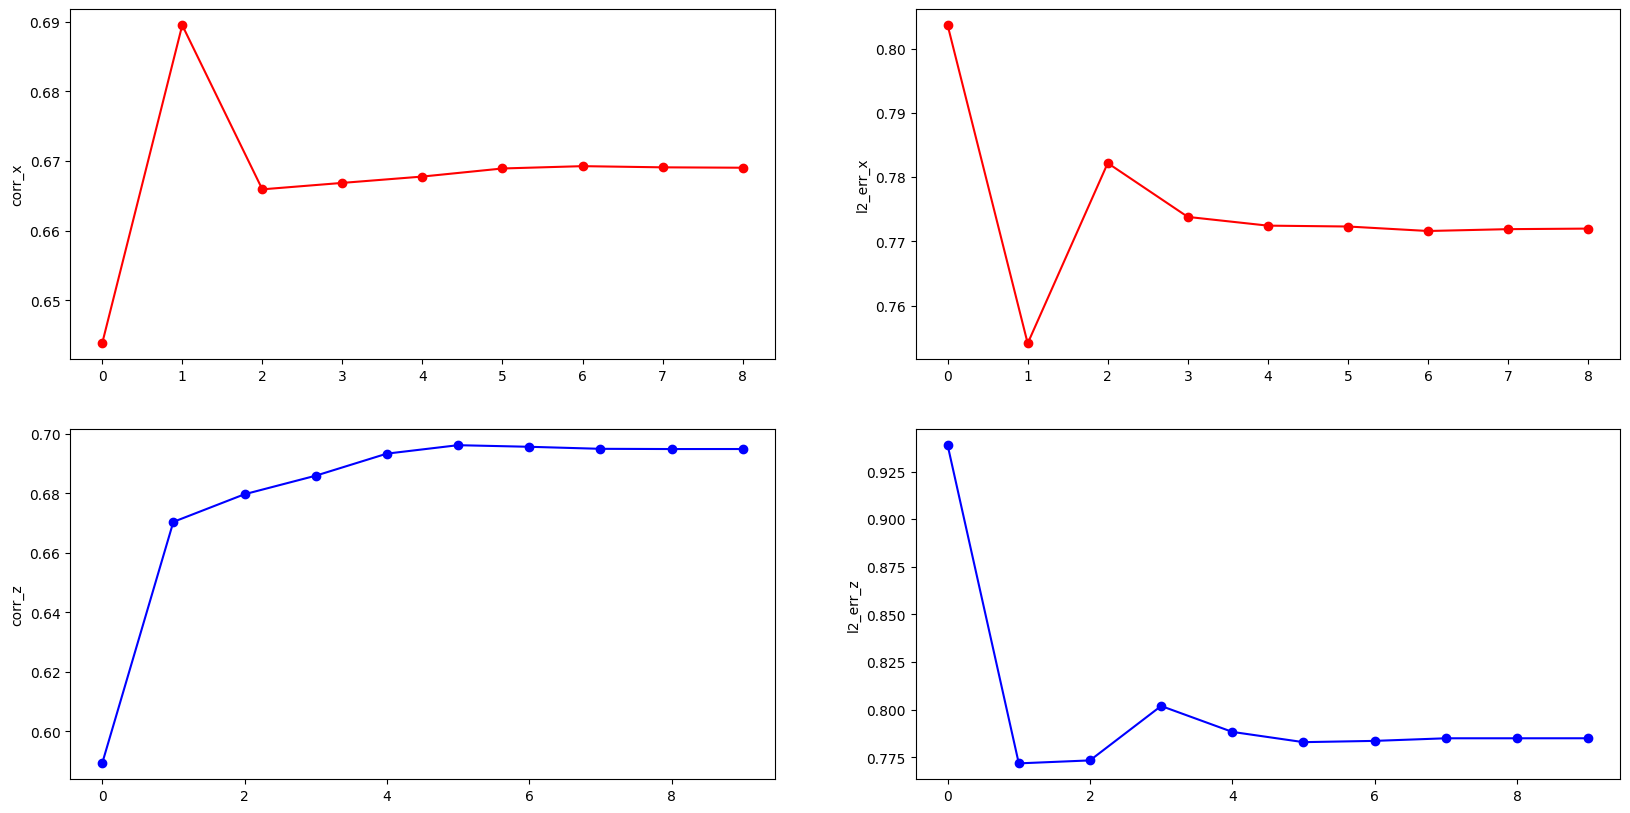

In [134]:
# running simulation
from numpy import random
import matplotlib.pyplot as plt

n=800
m=800
p=0.4
la=0.4
# This is where the sigma is defined. Note that the scope of this definition extends to gvamp
sigma=1
omega=1
h2=0.5
    
X,beta,y,alpha = sim_model(n,m,p,la,sigma,h2)

# These are the initial estimates
# gam1 = 1.0 / (sigma)
gam1 = 1e-2

print("gam1 = ", gam1)
pr = prior(la = la, sigmas = [sigma], omegas = [omega])
mu = 0

print("Var(y) = ", np.var(y))
# tau1 = 1.0 / np.var(X @ beta)
tau1 = 1e-1
print("tau1 = ", tau1)
print("alpha = ", alpha)

# we start with an initialization that compleately complies with the assumptions
r1 = np.zeros((m,1))
#r1 = beta + random.normal(loc=0.0, scale=np.sqrt(1.0/gam1), size=[m,1])
p1 = np.zeros((n,1)) 
#p1 = X @ beta + random.normal(loc=0.0, scale=np.sqrt(1.0/tau1), size=[n,1])

maxiter = 10

est, gam1, corrs_x, l2_errs_x, corrs_z, l2_errs_z = gvamp(X, gam1, r1, tau1, p1, pr, y, alpha, mu, maxiter, beta)

plt.figure(figsize=(20, 10))
plt.subplot(221)
plt.ylabel('corr_x')
plt.plot(range(maxiter-1), corrs_x, 'ro-')
plt.subplot(222)
plt.ylabel('l2_err_x')
plt.plot(range(maxiter-1), l2_errs_x, 'ro-')
plt.subplot(223)
plt.ylabel('corr_z')
plt.plot(range(maxiter), corrs_z, 'bo-')
plt.subplot(224)
plt.ylabel('l2_err_z')
plt.plot(range(maxiter), l2_errs_z, 'bo-')
plt.show()


In [140]:
from tteVAMP.em import *

In [149]:
def den_beta_mixture(r, gam1, prior):
    """
    Actually computes a mixture of Gaussians instead of just one Gaussian 
    """
    # By treating the coefficients beta_i as independent, we work with 1d Gaussians only.
    
    A = (1-prior.la) * norm.pdf(r, loc=0, scale=np.sqrt(1.0/gam1)) # scale = standard deviation
    B = 0
    B_der = 0
    for e in prior.sigmas:
        pdf = norm.pdf(r, loc=0, scale=np.sqrt(e + 1.0/gam1))
        term1 = pdf * e * r / (e + 1/gam1)
        B += term1
        
        # Derivative of term1
        pdf_der = pdf * (-r / (e + 1.0/gam1))
        term2 = pdf_der * e * r / (e + 1/gam1)
        term3 = pdf * e / (e + 1/gam1)
        B_der += term2 + term3
    
    B *= prior.la
    B_der *= prior.la
    
    # Derivative of A
    A_der = A * (-r * gam1)
    
    # Derivative of ratio
    ratio = B / (A + B)
    ratio_der = ((A + B) * B_der - B * (A_der + B_der)) / (A + B)**2
    
    return ratio, ratio_der

In [160]:
# performs the update of the prior distribution
def update_Prior(old_prior, r1, gam1):
    print(old_prior.sigmas.shape)
    prior = old_prior
    r1 = np.asmatrix(r1)
    omegas = np.asmatrix(old_prior.omegas)
    sigmas = np.asmatrix(old_prior.sigmas)
    sigmas_max = max(old_prior.sigmas)
    gam1inv = 1.0/gam1
    # np.exp( - np.power(np.transpose(r1),2) / 2 @ (sigmas_max - sigmas) / (sigmas_max + gam1inv) / (sigmas + gam1inv)) has shape = (P,L) and  omegas / np.sqrt(gam1inv + sigmas) has shape = (1, L)
    beta_tilde=np.multiply( np.exp( - np.power(np.transpose(r1),2) / 2 @ (sigmas_max - sigmas) / (sigmas_max + gam1inv) / (sigmas + gam1inv)), omegas / np.sqrt(gam1inv + sigmas) )
    sum_beta_tilde = beta_tilde.sum(axis=1)
    beta_tilde=beta_tilde / sum_beta_tilde
    # pi.shape = (P, 1)
    pi = 1.0 / ( 1.0 + (1-prior.la * np.exp(-np.power(np.transpose(r1),2) / 2 * sigmas_max * gam1 / (sigmas_max + gam1inv) ) / np.sqrt(gam1inv) ) / sum_beta_tilde )
    gamma = np.divide(np.transpose(r1) * gam1, gam1 + 1.0/sigmas )
    # v.shape = (1,L)
    v = 1.0 / (gam1 + 1.0/sigmas)

    #updating sparsity level
    prior.la = np.mean(pi)
    #updating variances in the mixture
    prior.sigmas = (np.transpose(pi) @ np.multiply( beta_tilde , (np.power(gamma,2) + v)) ) / (np.transpose(pi) @ beta_tilde)
    #updating prior probabilities in the mixture
    prior.omegas = (np.transpose(pi) @ beta_tilde ) / np.sum(pi)
    
    return prior

In [152]:
def gvamp(X, gam1, r1, tau1, p1, prior, y, alpha, mu, maxiter, beta_true):
    #computing SVD decomposition of X
    [n,m] = X.shape
    u, s, vh = np.linalg.svd(X, full_matrices=False)
    print("s.shape = ", s.shape)
    Xbeta_true = X @ beta_true

    #storing measure of recovery quality
    l2_errs_x = []
    corrs_x = []
    l2_errs_z = []
    corrs_z = []
    
    for it in range(maxiter):
        print("**** iteration = ", it, " **** \n" )
        print("EM Update of the prior of the coefficients beta")
        prior = update_Prior(prior, r1, gam1)
        
        # Denoising x (the effect sizes)
        print("->DENOISING")
        ############################################################
        # Conditional expectation of x given r and the parameters of the prior distribution of x
        # This is applied elementwise to r1
        ############################################################
        x1_hat, den_beta_der = den_beta_mixture(r1, gam1, prior)

        ############################################################
        print("x1_hat[2] = ", x1_hat[2])
        if np.linalg.norm(x1_hat) != 0:
            # Cosine similarity
            corr = np.dot(x1_hat.transpose(), beta_true) / np.linalg.norm(x1_hat) / np.linalg.norm(beta_true)
            print("corr(x1_hat, beta_true) = ", corr[0][0])
            corrs_x.append(corr[0][0])
            l2_err = np.linalg.norm(x1_hat - beta_true) / np.linalg.norm(beta_true)
            print("l2 error for x1_hat = ", l2_err)
            l2_errs_x.append(l2_err)
        ############################################################

        # This seems to be different from overleaf
        # But in fact these two are equivalent
        alpha1 = np.mean( den_beta_der )

        print("alpha1 = ", alpha1)
        gam2 = gam1 * (1-alpha1) / alpha1
        r2 = (x1_hat - alpha1 * r1) / (1-alpha1)
        print("true gam2 = ", 1.0 / np.var(r2 - beta_true))
        print("gam2 = ", gam2)
        
        # Denoising z (the genetic predictor)
        z1_hat = den_z(p1, tau1, y, alpha, mu) 

        ############################################################
        # Cosine similarity
        corr = np.dot(z1_hat.transpose(), Xbeta_true) / np.linalg.norm(z1_hat) / np.linalg.norm(Xbeta_true)
        print("corr(z1_hat, X*beta_true) = ", corr[0][0])
        corrs_z.append(corr[0][0])
        l2_err = np.linalg.norm(z1_hat - Xbeta_true) / np.linalg.norm(Xbeta_true)
        print("l2 error for z1_hat = ", l2_err)
        l2_errs_z.append(l2_err)
        ############################################################

        beta_1 = np.mean( der_den_z(p1, tau1, y, alpha, mu) )
        print("v1 = ", beta_1)
        tau2 = tau1 * (1-beta_1) / beta_1
        p2 = (z1_hat - beta_1 * p1) / (1-beta_1)
        print("true tau2 = ", 1.0 / np.var(p2 - Xbeta_true))
        print("tau2 =", tau2)
        
        # LMMSE estimation of x
        print("->LMMSE")
        dk = 1.0 / (tau2 * s * s + gam2)
        x2_hat = vh.transpose() @ np.diag(dk) @ (tau2 * np.diag(s).transpose() @ u.transpose() @ p2 + gam2 * vh @ r2)

        ############################################################
        # Cosine similarity
        print("corr(x2_hat, beta_true) = ", np.dot(x2_hat.transpose(), beta_true) / np.linalg.norm(x2_hat) / np.linalg.norm(beta_true))
        print("l2 error for x2_hat = ", np.linalg.norm(x2_hat - beta_true) / np.linalg.norm(beta_true))
        ############################################################

        alpha2 = np.sum( gam2 / (tau2 * s * s + gam2) ) / m
        print("alpha2 = ", alpha2)
        gam1 = gam2 * (1-alpha2) / alpha2
        r1 = (x2_hat - alpha2 * r2) / (1-alpha2)
        print("true gam1 = ", 1.0 / np.var(r1 - beta_true))
        print("gam1 = ", gam1)
        
        # LMMSE estimation of z
        z2_hat = np.matmul(X, x2_hat)

        ############################################################
        # Cosine similarity
        print("corr(z2_hat, beta_true) = ", np.dot(z2_hat.transpose(), Xbeta_true) / np.linalg.norm(z2_hat) / np.linalg.norm(Xbeta_true))
        print("l2 error for z2_hat = ", np.linalg.norm(z2_hat - Xbeta_true) / np.linalg.norm(Xbeta_true))
        ############################################################

        beta2 = (1-alpha2) * m / n
        tau1 = tau2 * (1-beta2) / beta2
        p1 = (z2_hat - beta2 * p2) / (1-beta2)
        print("true tau1 = ", 1.0 / np.var(p1 - Xbeta_true))
        print("tau1 = ", tau1)
        print("\n")

    return x1_hat, gam1, corrs_x, l2_errs_x, corrs_z, l2_errs_z

In [161]:
pr = prior(la = la, sigmas = np.array([1 for _ in range(X.shape[1])]), omegas = np.array([1/X.shape[1] for _ in range(X.shape[1])]) )

In [162]:
X.shape[1]

800

In [163]:
est, gam1, corrs_x, l2_errs_x, corrs_z, l2_errs_z = gvamp(X, gam1, r1, tau1, p1, pr, y, alpha, mu, maxiter, beta)


































































s.shape =  (800,)
**** iteration =  0  **** 

EM Update of the prior of the coefficients beta
(800,)


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1 is different from 800)

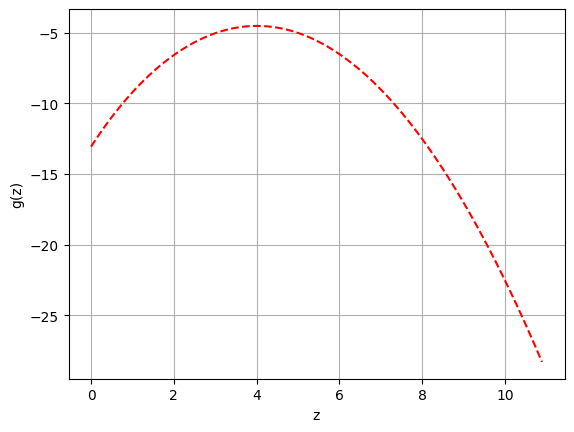

In [5]:
# plotting function g(z)

import numpy as np
import sympy
import matplotlib.pyplot as plt

emc = float( sympy.S.EulerGamma.n(10) )

tau1 = 1
p = 5
mu = 0
alpha = 1
y = 1

def g(z):
    return -alpha * z - np.power(y, alpha) * np.exp(-alpha*(z+mu) - emc) - (z-p)*(z-p)*tau1/2 

net = np.arange(0, 11.0, 0.1)

plt.figure()
plt.plot(net, g(net), 'r--')
plt.grid(True)
plt.xlabel('z')
plt.ylabel('g(z)')
plt.savefig('gz.png')
plt.show()